In [1]:
import os
import sys
from pprint import pprint

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import pyogrio

In [3]:
# geoid = '36001013507'
geoid = '36001'

In [2]:
##### Imports Config #####
%load_ext autoreload
%autoreload 

In [4]:
%reload_ext autoreload

local_modules_path = os.path.abspath('../../001.002_pjt_utah_redundancy/')

if local_modules_path not in sys.path:
    print('append local_modules_path')
    sys.path.append(local_modules_path)

from src.utils.us_census_tiger import get_region_boundary_gdf, get_buffered_region_gdf
from src.utils.osm_helpers import create_enriched_osmnx_graph_using_buffered_region_gdfs

append local_modules_path


In [5]:
floodplains_gpkg_path = os.path.join('../data/raw/avail/merged_floodplains/hazmit_db.s379_v841_avail_nys_floodplains_merged.1730233335.gpkg.zip')
osm_pbf = os.path.join('../data/raw/osm/vehicle-nonservice-roadways_us-northeast-230819.osm.pbf')

In [ ]:
def show_gdfs(
    region_gdfs,
    figsize=(10, 10),
    colors=None,
    alpha=None,
    linewidths=None,
    add_basemaps=True
):
    fig, ax = plt.subplots(figsize=figsize)

    for i, region_gdf in enumerate(region_gdfs):
        region_gdf.plot(
            ax=ax,
            alpha=alpha[i] if alpha else 0.25,
            color=colors[i] if colors else 'blue',
            linewidth=linewidths[i] if linewidths else 2
        )

    if add_basemaps:
        cx.add_basemap(
            ax,
            crs=region_gdf.crs,
            source=cx.providers.Esri.WorldShadedRelief,
            attribution='',
            alpha=1,
        )

        cx.add_basemap(
            ax,
            crs=region_gdf.crs,
            source=cx.providers.OpenTopoMap,
            attribution='',
            alpha=0.2,
        )

        cx.add_attribution(
            ax=ax,
            text=(
                'Hillshade: ' 
                + cx.providers.Esri.WorldShadedRelief.attribution
                + '\n'
                + 'Topography: '
                + cx.providers.OpenTopoMap.attribution
            )
        )


    ax.set_axis_off() # Remove axis ticks and labels
    plt.show()


In [7]:
# We create an empty GeoDataFrame just to get the CRS.
# We MUST use this CRS to set the CRS of the region_boundary_gdf
#   before using it as the mask to read the floodplains dataset.
## empty_gpd = gpd.read_file(
##     filename=f'/vsizip/{floodplains_gpkg_path}',
##     engine='pyogrio',
##     layer='merged_floodplains',
##     where='False',
## )

# Trying to speed up getting the CRS from the floodplains dataset.
floodplains_info = pyogrio.read_info(
    f'/vsizip/{floodplains_gpkg_path}',
    engine='pyogrio',
    layer='merged_floodplains',
    force_feature_count=False,
    limit=0
)

/home/avail/AVAIL/avail-research-road-network-resiliency/.venv/lib/python3.12/site-packages/pyogrio/core.py:279: RuntimeWarning: driver GPKG does not support open option ENGINE
  return ogr_read_info(
/home/avail/AVAIL/avail-research-road-network-resiliency/.venv/lib/python3.12/site-packages/pyogrio/core.py:279: RuntimeWarning: driver GPKG does not support open option LIMIT
  return ogr_read_info(


In [8]:
region_boundary_gdf = get_region_boundary_gdf(
    geoid
)
region_boundary_gdf.to_crs(floodplains_info['crs'], inplace=True)

<Axes: >

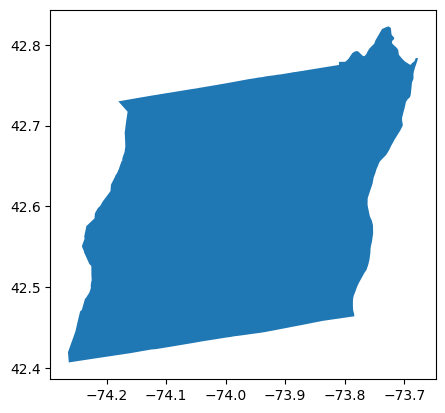

In [9]:
region_boundary_gdf.plot()

In [10]:
buffered_region_gdf = get_buffered_region_gdf(
    region_gdf=region_boundary_gdf,
    buffer_dist_mi=5 
)

<Axes: >

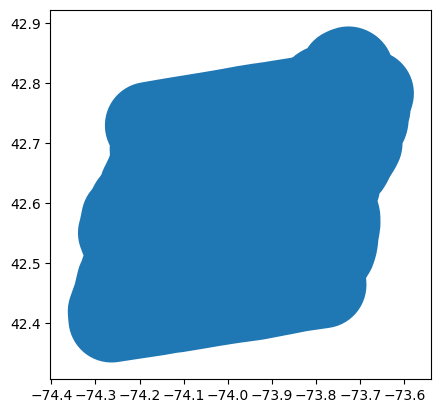

In [11]:
buffered_region_gdf.plot()

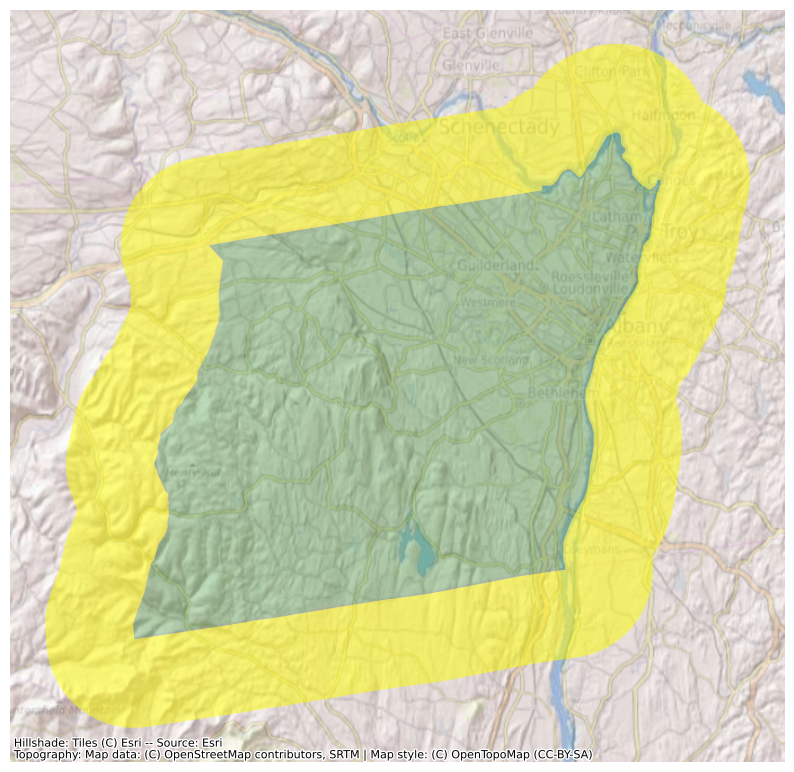

In [12]:
show_gdfs(
    region_gdfs=[
        region_boundary_gdf,
        buffered_region_gdf.overlay(region_boundary_gdf, how='difference'),
    ],
    colors=['green', 'yellow'],
    alpha=[0.25, 0.5]
)

In [13]:
floodplain_gpd = gpd.read_file(
    filename=f'/vsizip/{floodplains_gpkg_path}',
    engine='pyogrio',
    mask=buffered_region_gdf.loc[0, 'geometry'],
    layer='merged_floodplains',
    geometry_type='MultiPolygon',
).overlay(
    # This portion "clips" the floodplain geometries
    right=buffered_region_gdf,
    how='intersection',
    keep_geom_type=True,
    make_valid=True
)

/home/avail/AVAIL/avail-research-road-network-resiliency/.venv/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GPKG does not support open option GEOMETRY_TYPE
  return ogr_read(


In [14]:
subdivided_floodplain_geoms = []

for g in floodplain_gpd.geometry:
    cut_geom = ox.utils_geo._quadrat_cut_geometry(
        g,
        0.005
    )

    subdivided_floodplain_geoms.append(cut_geom)

In [15]:
subdivided_floodplain_gdf = gpd.GeoDataFrame(geometry=subdivided_floodplain_geoms)

<Axes: >

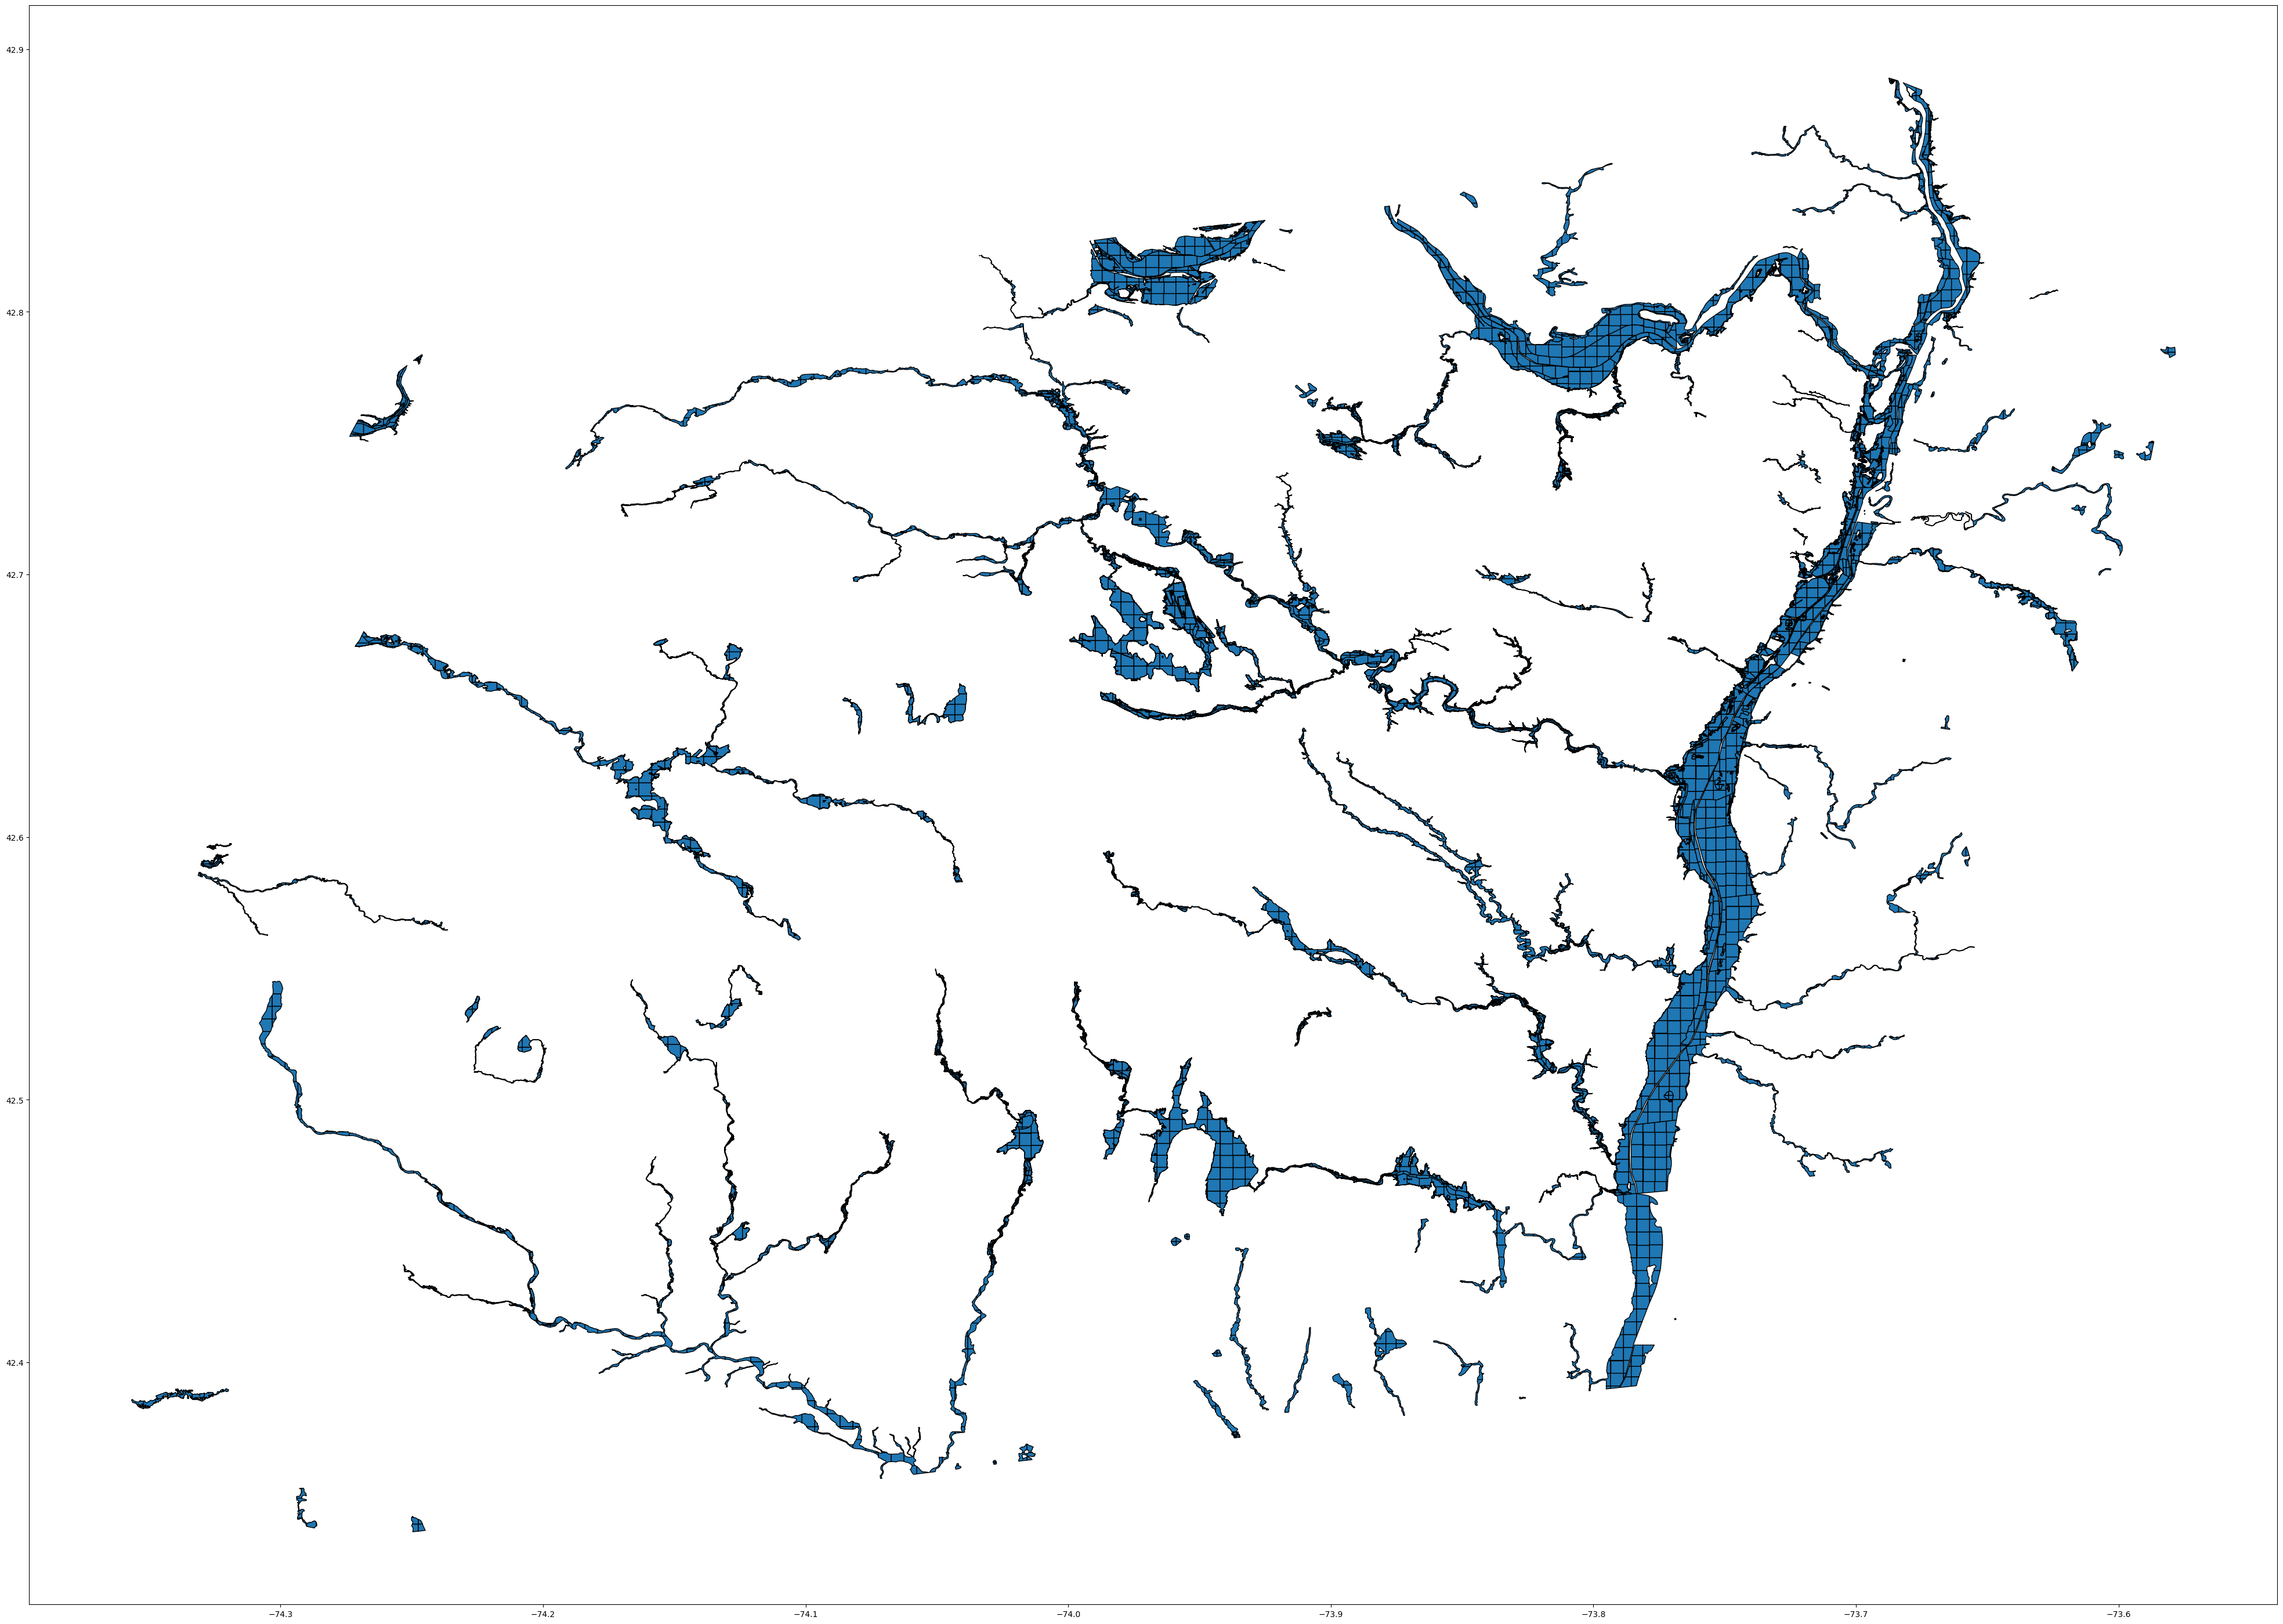

In [16]:
subdivided_floodplain_gdf.plot(figsize=(50, 50), edgecolor='black')

In [17]:
subdivided_floodplain_idx = subdivided_floodplain_gdf.sindex

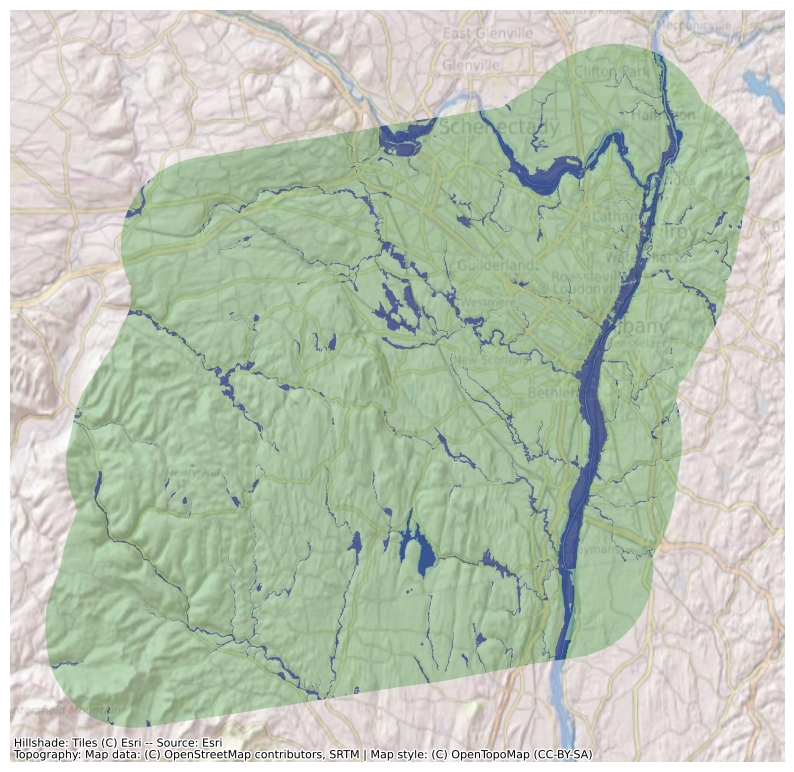

In [19]:
show_gdfs(
    region_gdfs=[
        # buffered_region_diff_floodplains_gdf,
        buffered_region_gdf,
        floodplain_gpd,
    ],
    colors=['green', 'navy'],
    alpha=[0.25, 0.5]
)

In [20]:
osm_network_data = create_enriched_osmnx_graph_using_buffered_region_gdfs(
    osm_pbf=osm_pbf,
    region_gdf=region_boundary_gdf,
    buffered_region_gdf=buffered_region_gdf,
)

In [21]:
edges_gdf = osm_network_data['edges_gdf']

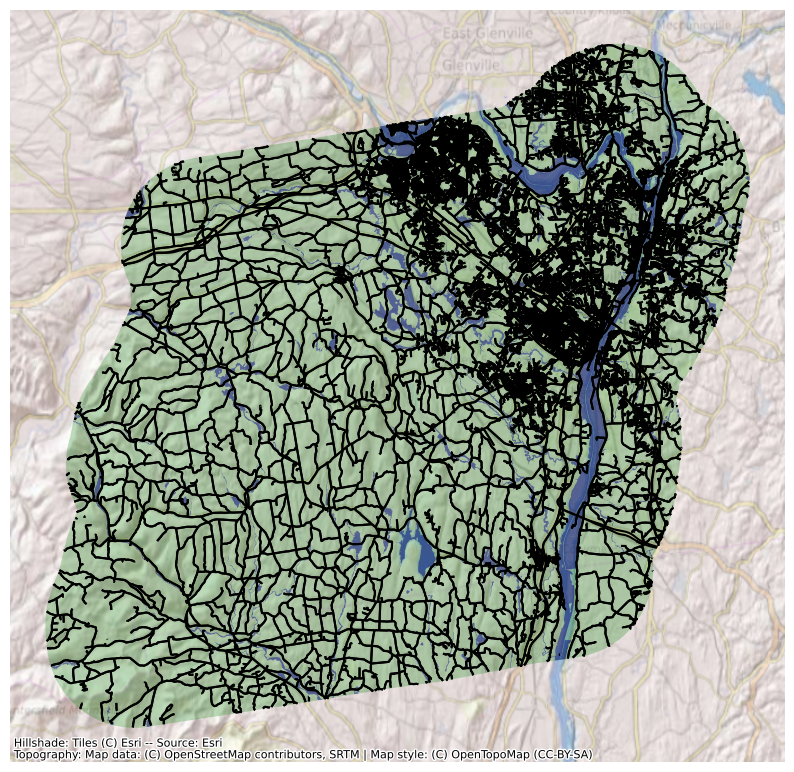

In [22]:
show_gdfs(
    region_gdfs=[
        # buffered_region_diff_floodplains_gdf,
        buffered_region_gdf,
        floodplain_gpd,
        osm_network_data['edges_gdf'],
    ],
    colors=['green', 'navy', 'black'],
    alpha=[0.25, 0.5, 1]
)


In [23]:
floodplains_intersect_edges_query_result = subdivided_floodplain_idx.query(
    geometry=edges_gdf.geometry,
    predicate='intersects'
)

In [24]:
len(floodplains_intersect_edges_query_result[0])

6496

In [25]:
# TODO: Collect flood zone types.

intersected = set()

counter = 0
for edge_idx, subdivided_floodplain_idx in zip(*floodplains_intersect_edges_query_result):
    counter += 1

    if counter % 500 == 0:
        print(counter)

    if edge_idx in intersected:
        continue

    if edges_gdf.iloc[edge_idx].geometry.intersects(subdivided_floodplain_gdf.iloc[subdivided_floodplain_idx].geometry):
        intersected.add(edge_idx)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


In [ ]:
edges_intersecting_floodplains_indexes = list(intersected)

In [53]:
edges_gdf['intersects_flood_plain'] = [
    x in edges_intersecting_floodplains_indexes for x in range(len(edges_gdf))
]

In [38]:
edges_nonintersecting_floodplains_indexes = list(set(range(len(edges_gdf))).difference(intersected))

In [39]:
edges_intersecting_floodplains_gdf = edges_gdf.iloc[edges_intersecting_floodplains_indexes]
edges_nonintersecting_floodplains_gdf = edges_gdf.iloc[edges_nonintersecting_floodplains_indexes]

<Axes: >

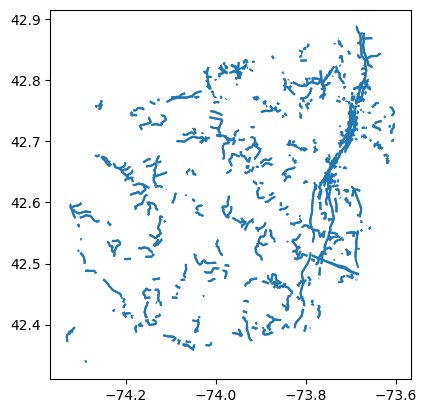

In [28]:
edges_intersecting_floodplains_gdf.plot()

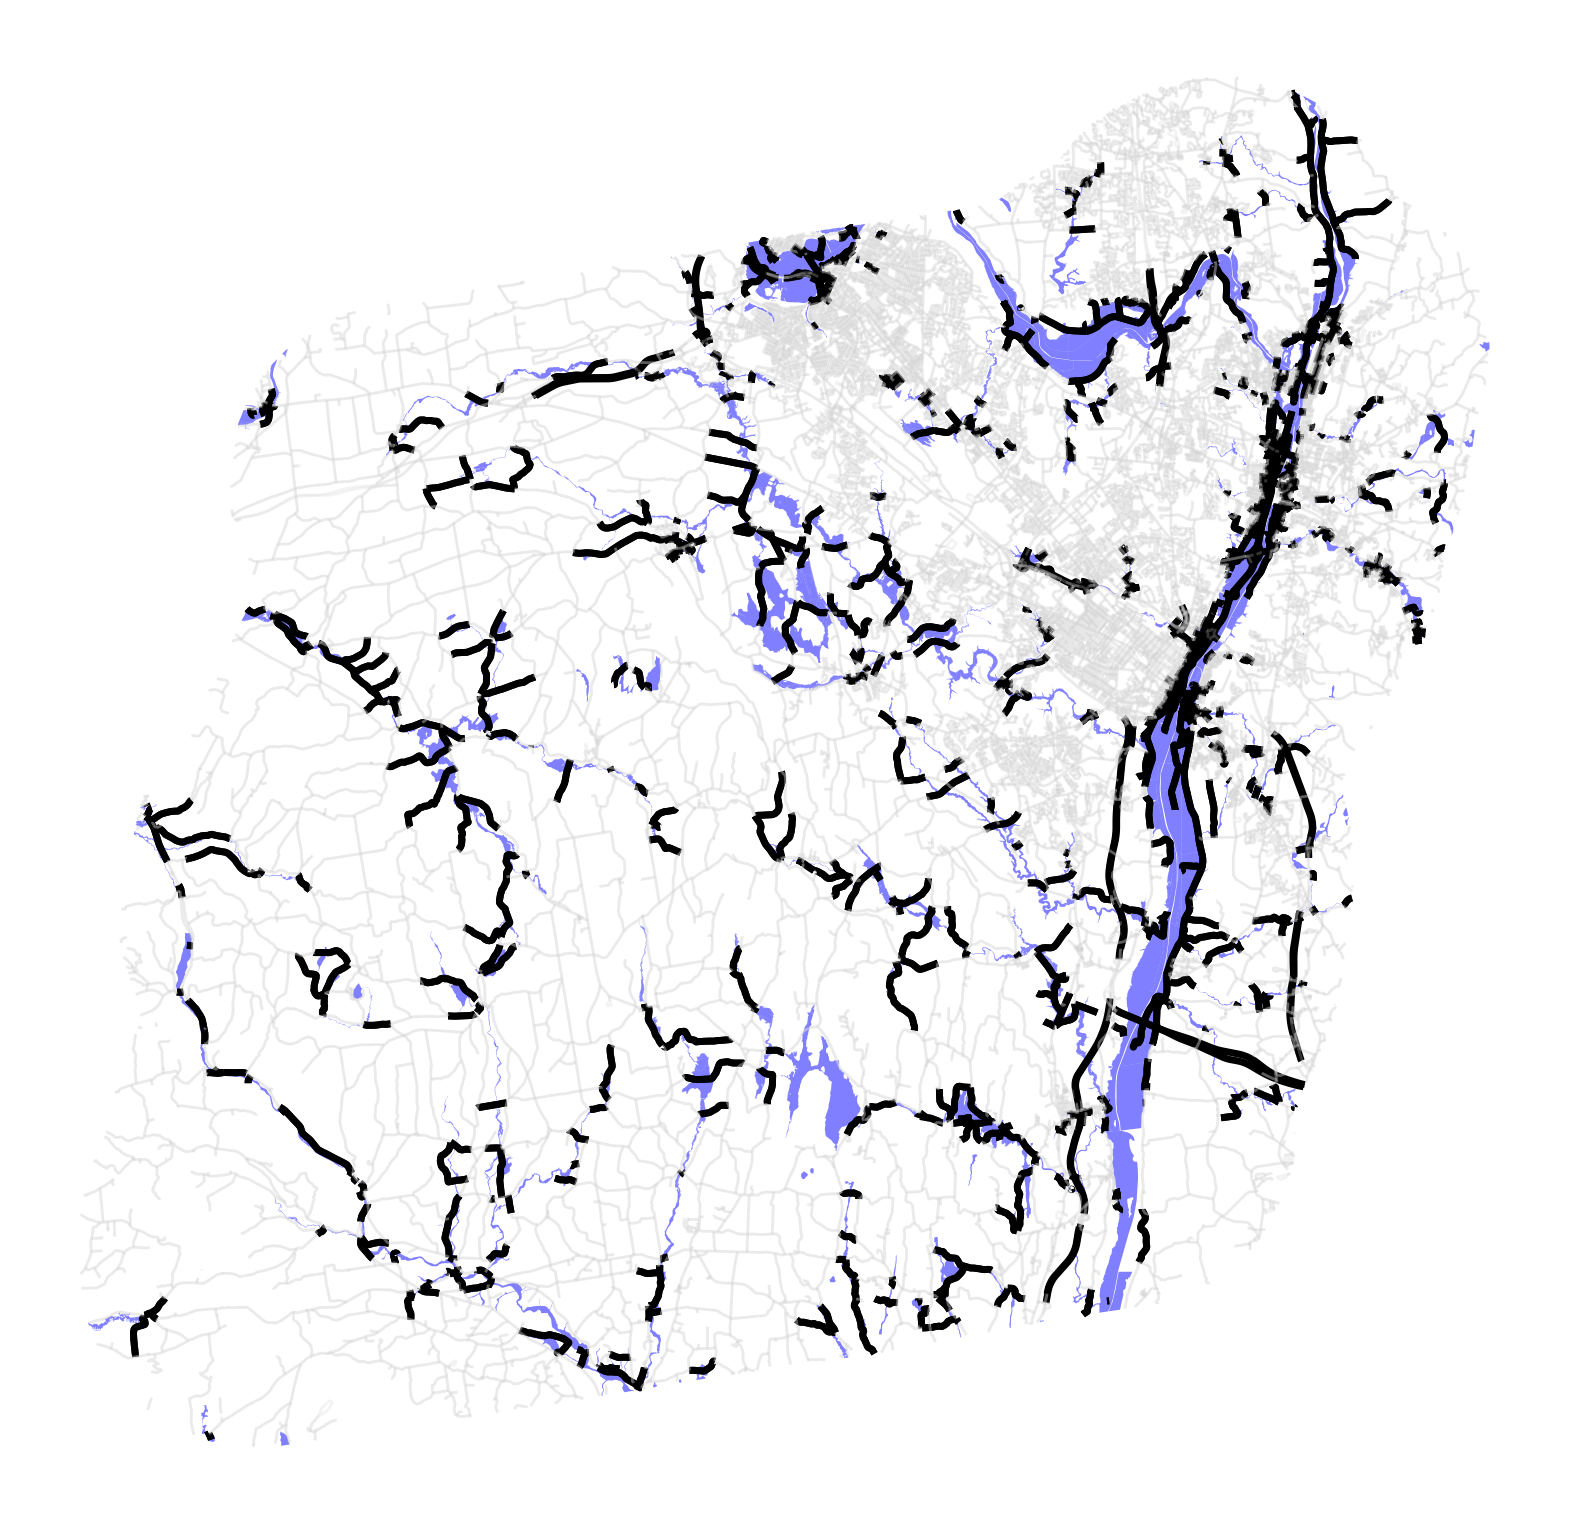

In [55]:
show_gdfs(
    region_gdfs=[
        # buffered_region_diff_floodplains_gdf,
        # osm_network_data['edges_gdf'],
        floodplain_gpd,
        edges_intersecting_floodplains_gdf,
        edges_nonintersecting_floodplains_gdf
    ],
    figsize=(20, 20),
    # colors=['green', 'darkblue', 'gray', 'black'],
    colors=['blue', 'black', 'lightgray'],
    alpha=[0.5, 1, 0.25],
    linewidths=[1, 5, 2],
    add_basemaps=False
)

In [ ]:
gpd.GeoDataFrame(edges_gdf).to_file(
    filename=f'roadway-floodplain-intersections_{geoid}.gpkg',
    layer='roadways',
    driver='GPKG',
    engine='pyogrio'
)